<a href="https://colab.research.google.com/github/QuocTrieu1293/K-Means-Implementation-on-PySpark/blob/main/BigData_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark py4j

In [ ]:
from pyspark.sql import SparkSession, Row
spark = SparkSession.builder \
    .appName("K_MEAN")\
    .getOrCreate()

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.column import *
import numpy as np
import pandas as pd

## Khám phá dữ liệu

In [ ]:
df = spark.read.csv("./seattle-weather.csv", header=True, inferSchema=True)
df.printSchema()
df.show(3)

root
 |-- date: date (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- wind: double (nullable = true)
 |-- weather: string (nullable = true)

+----------+-------------+--------+--------+----+-------+
|      date|precipitation|temp_max|temp_min|wind|weather|
+----------+-------------+--------+--------+----+-------+
|2012-01-01|          0.0|    12.8|     5.0| 4.7|drizzle|
|2012-01-02|         10.9|    10.6|     2.8| 4.5|   rain|
|2012-01-03|          0.8|    11.7|     7.2| 2.3|   rain|
+----------+-------------+--------+--------+----+-------+
only showing top 3 rows



In [ ]:
df.describe().drop('weather').show()
dict_null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
df_null_counts = pd.DataFrame.from_dict(dict_null, orient="index", columns=['Số giá trị null'])
print(df_null_counts)

+-------+------------------+-----------------+-----------------+------------------+
|summary|     precipitation|         temp_max|         temp_min|              wind|
+-------+------------------+-----------------+-----------------+------------------+
|  count|              1461|             1461|             1461|              1461|
|   mean|3.0294318959616757|16.43908281998628|8.234770704996588| 3.241136208076654|
| stddev|  6.68019432231474|7.349758097360173|5.023004179961267|1.4378250588746202|
|    min|               0.0|             -1.6|             -7.1|               0.4|
|    max|              55.9|             35.6|             18.3|               9.5|
+-------+------------------+-----------------+-----------------+------------------+

               Số giá trị null
date                         0
precipitation                0
temp_max                     0
temp_min                     0
wind                         0
weather                      0


In [ ]:
df.groupBy('weather').count().orderBy('count', ascending=False).show()
print("Số giá trị của cột weather:", df.select('weather').distinct().count())

+-------+-----+
|weather|count|
+-------+-----+
|   rain|  641|
|    sun|  640|
|    fog|  101|
|drizzle|   53|
|   snow|   26|
+-------+-----+

Số giá trị của cột weather: 5


## Chuẩn hoá dữ liệu

In [ ]:
normalized_cols = ['precipitation', 'temp_max', 'temp_min', 'wind'] # Các cột dữ liệu cần chuẩn hoá

# chuẩn hoá min-max
min_values = df.agg(*[F.min(col).alias(col) for col in normalized_cols]).first().asDict()
max_values = df.agg(*[F.max(col).alias(col) for col in normalized_cols]).first().asDict()
print("min_values:\n", min_values)
print("max_values:\n", max_values)
def MinMaxNormalize(r):
  nor = r.asDict()
  for col in normalized_cols:
     nor[col + '_nor'] = (r[col] - min_values[col]) / (max_values[col] - min_values[col])
  return Row(**nor)

df_min_max = df.rdd.map(MinMaxNormalize).toDF()
print('\nChuẩn hoá Min-Max:\n')
df_min_max.show(3)
df_min_max.select(['precipitation_nor', 'temp_max_nor', 'temp_min_nor', 'wind_nor']).describe().show()

# chuẩn hoá z-score
mean_values = df.agg(*[F.mean(col).alias(col) for col in normalized_cols]).first().asDict()
stddev_values = df.agg(*[F.stddev(col).alias(col) for col in normalized_cols]).first().asDict()
print("mean_values:\n", mean_values)
print("stddev_values:\n", stddev_values)
def Z_Score(r):
  nor = r.asDict();
  for col in normalized_cols:
     nor[col + '_nor'] = (r[col] - mean_values[col]) / stddev_values[col]
  return Row(**nor)

df_zscore = df.rdd.map(Z_Score).toDF()
print('\nChuẩn hoá Z-Score:\n')
df_zscore.show(3)
df_zscore.select(['precipitation_nor', 'temp_max_nor', 'temp_min_nor', 'wind_nor']).describe().show(truncate=False)

min_values:
 {'precipitation': 0.0, 'temp_max': -1.6, 'temp_min': -7.1, 'wind': 0.4}
max_values:
 {'precipitation': 55.9, 'temp_max': 35.6, 'temp_min': 18.3, 'wind': 9.5}

Chuẩn hoá Min-Max:

+----------+-------------+--------+--------+----+-------+--------------------+-------------------+-------------------+------------------+
|      date|precipitation|temp_max|temp_min|wind|weather|   precipitation_nor|       temp_max_nor|       temp_min_nor|          wind_nor|
+----------+-------------+--------+--------+----+-------+--------------------+-------------------+-------------------+------------------+
|2012-01-01|          0.0|    12.8|     5.0| 4.7|drizzle|                 0.0| 0.3870967741935484| 0.4763779527559055|0.4725274725274725|
|2012-01-02|         10.9|    10.6|     2.8| 4.5|   rain| 0.19499105545617174|0.32795698924731176|0.38976377952755903|0.4505494505494505|
|2012-01-03|          0.8|    11.7|     7.2| 2.3|   rain|0.014311270125223615|0.35752688172043007| 0.5629921259842521|

## Cài đặt thuật toán K-Means

In [ ]:
# Cài đặt KMean
from pyspark.sql.types import IntegerType, DoubleType

class K_Mean:
    def __init__(self, k=2, predictCol='prediction', seed=1):
      self.k = k
      self.centroids = None
      self.predictCol = predictCol
      self.seed=seed
      self.wcss = None

    @staticmethod
    def squared_euclidean_distance(x, y): # Dùng squared euclid, không lấy căn bậc 2
      return sum((x[i] - y[i])**2 for i in range(len(x)))

    def clusters_distances(self, features):
      return [K_Mean.squared_euclidean_distance(self.centroids[i],features) for i in range(self.k)]

    def assign_to_centroid(self, features):
      distances = self.clusters_distances(features)
      nearest_cluster = min(range(self.k), key=lambda i: distances[i])
      return nearest_cluster

    def fit(self, df, feature_cols):
      # tạo cột features
      df = df.withColumn('features', F.array(feature_cols))
      self.wcss = float('inf')
      self.centroids = None
      for i in range(5):
        centroids = self.centroids
        # khởi tạo k centers ban đầu
        self.centroids = df.select('features').rdd.map(lambda r: r.features).takeSample(False, num=self.k, seed=self.seed)
        self.seed += 1

        # bắt đầu chạy thuật toán
        while True:
          # hàm udf để chọn cluster cho một điểm dữ liệu
          assign_to_centroid_udf = F.udf(self.assign_to_centroid, IntegerType())
          df = df.withColumn(self.predictCol, assign_to_centroid_udf(F.col('features')))

          avg_clusters = df.groupBy(self.predictCol).agg(*[F.mean(c).alias(c) for c in feature_cols]).withColumn('avg_features', F.array(feature_cols)).collect()
          new_centroids = self.centroids
          for cluster in avg_clusters:
            new_centroids[cluster[self.predictCol]] = cluster['avg_features']

          if (max(K_Mean.squared_euclidean_distance(self.centroids[i], new_centroids[i]) for i in range(self.k))**0.5) < 0.0001:
            break
          self.centroids = new_centroids
        # Kết thúc while loop

        # Tính độ đo WCSS dùng đánh giá việc phân cụm
        dist_udf = F.udf(lambda features, prediction: K_Mean.squared_euclidean_distance(features, self.centroids[prediction]), DoubleType())
        wcss = df.withColumn('dist', dist_udf(F.col('features'), F.col(self.predictCol))).agg(F.sum('dist')).first()[0]
        if self.wcss > wcss:
          self.wcss = wcss
        else:
          self.centroids = centroids
        # Kết thúc for loop

      # Kết thúc method fit()

    def transform(self, df, feature_cols):
      df = df.withColumn('features', F.array(feature_cols))
      assign_to_centroid_udf = F.udf(self.assign_to_centroid, IntegerType())
      df = df.withColumn(self.predictCol, assign_to_centroid_udf(F.col('features')))
      return df


## Cài đặt lớp tính hệ số Silhouette dùng để đánh giá việc phân cụm của K-Mean

In [ ]:
# Cài đặt tính hệ số Silhouette để đánh giá việc phân cụm của KMean
from pyspark.sql.types import DoubleType

class SilhouetteEvaluator:
  def __init__(self, predictCol='prediction'):
    self.predictCol = predictCol

  def evaluate(self, df):
    df = df.select('date', 'features', self.predictCol)
    cluster_df = df.withColumnRenamed('features', 'features_') \
                  .withColumnRenamed(self.predictCol, 'cluster') \
                  .withColumnRenamed('date', 'date_')
    df = df.crossJoin(cluster_df).filter(F.col('date') != F.col('date_'))
    distance_udf = F.udf(lambda x, y: sum((x[i]-y[i])**2 for i in range(len(x))), DoubleType()) # Dùng squared euclid, không lấy căn bậc 2
    df = df.withColumn('dist', distance_udf(F.col('features'), F.col('features_')))

    # Tính giá trị b(i) cho từng điểm dữ liệu
    b = df.filter(F.col(self.predictCol) != F.col('cluster')) \
        .groupBy('date', 'cluster').agg(F.mean('dist').alias('avg_dist')) \
        .groupBy('date').agg(F.min('avg_dist').alias('b_i'))

    # Tính giá trị a(i) cho từng điểm dữ liệu
    a = df.filter(F.col(self.predictCol) == F.col('cluster')) \
        .groupBy('date').agg(F.mean('dist').alias('a_i'))

    # Tính hệ số trung bình Silhouette cho việc phân cụm
    silhouette_score = a.join(b, 'date') \
                        .withColumn('s_i',(F.col('b_i') - F.col('a_i')) / F.greatest(F.col('a_i'), F.col('b_i'))) \
                        .agg(F.mean('s_i')).first()[0]
    return silhouette_score


## Thực nghiệm

#### Chọn số cụm K tối ưu bằng Elbow Method và hệ số Silhouette

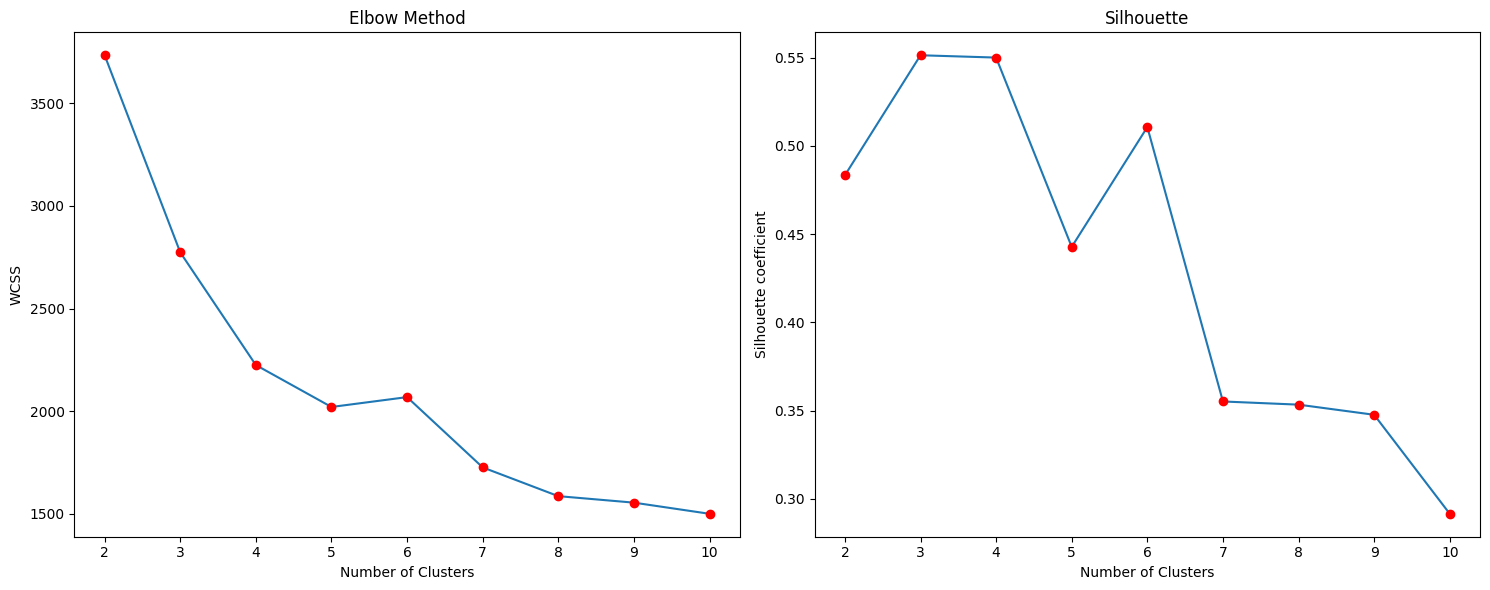

In [ ]:
# Chọn số cụm k cho thuật toán K-Mean dựa vào Elbow Method và hệ số Silhouette

import matplotlib.pyplot as plt
import numpy as np

feature_cols = ['precipitation_nor', 'temp_max_nor', 'temp_min_nor', 'wind_nor']
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

wcss_list = []
silhouette_list = []

for k in range(2,11):
    kmean = K_Mean(k)
    kmean.fit(df_zscore, feature_cols)
    df_fit = kmean.transform(df_zscore, feature_cols)
    evaluator = SilhouetteEvaluator()
    silhouette_score = evaluator.evaluate(df_fit)
    wcss_list.append(kmean.wcss)
    silhouette_list.append(silhouette_score)

# Elbow Method
axs[0].plot(np.arange(2, 11), wcss_list, '-')
axs[0].plot(np.arange(2,11), wcss_list, 'o', color='red')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('WCSS')
axs[0].set_title('Elbow Method')

# Silhouette
axs[1].plot(np.arange(2, 11), silhouette_list, '-')
axs[1].plot(np.arange(2,11), silhouette_list, 'o', color='red')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette coefficient')
axs[1].set_title('Silhouette')

plt.tight_layout()
plt.show()

#### Thực hiện phân cụm dữ liệu

In [ ]:
# Thực hiện training mô hình trên dữ liệu df_zscore với k = 4

kmean = K_Mean(k=4)
kmean.fit(df_zscore,feature_cols)

In [ ]:
# Giá trị các centroids và wcss sau khi train

print('centroids:')
for centroid in kmean.centroids:
  print(centroid)
print('\nWCSS:', kmean.wcss)

centroids:
[-0.05115713282887737, -0.5144709004093946, -0.4031301744140794, 1.2023089562248654]
[-0.18888445099916307, -0.6387667848666028, -0.6878702451702778, -0.6269401970426495]
[2.803215257816656, -0.35461786806223405, 0.06492894973362687, 1.08734316238199]
[-0.3920632133753182, 1.1487554752849358, 1.0333538082707596, -0.3512503971864999]

WCSS: 2224.8662391929133


+----------+-------------+--------+--------+----+-------+--------------------+-------------------+--------------------+-------------------+--------------------+----------+
|      date|precipitation|temp_max|temp_min|wind|weather|   precipitation_nor|       temp_max_nor|        temp_min_nor|           wind_nor|            features|prediction|
+----------+-------------+--------+--------+----+-------+--------------------+-------------------+--------------------+-------------------+--------------------+----------+
|2012-01-01|          0.0|    12.8|     5.0| 4.7|drizzle|-0.45349457662362636|-0.4951296045094783| -0.6439912429102402| 1.0146323316031178|[-0.4534945766236...|         0|
|2012-01-02|         10.9|    10.6|     2.8| 4.5|   rain|    1.17819448421541|-0.7944591839129391|  -1.081976146203107| 0.8755333509826664|[1.17819448421541...|         0|
|2012-01-03|          0.8|    11.7|     7.2| 2.3|   rain| -0.3337375813326879|-0.6447943942112089|-0.20600633961737366|-0.6545554358422977|[

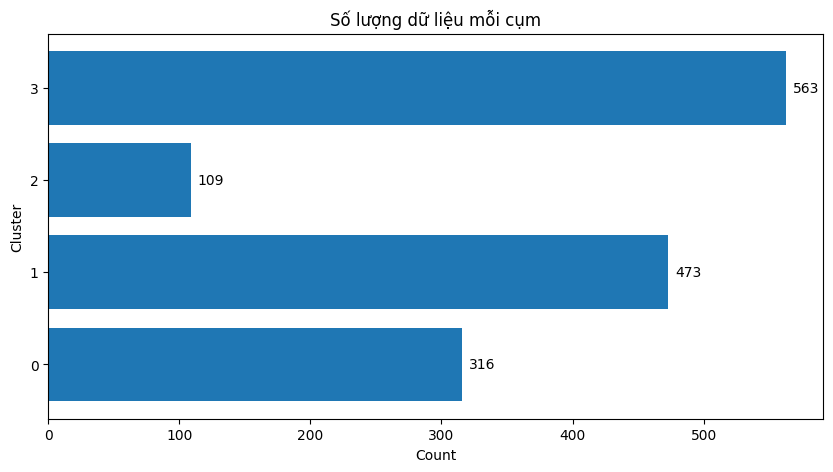



+----------+-------+-----+
|prediction|weather|count|
+----------+-------+-----+
|         0|drizzle|    4|
|         0|    fog|    8|
|         0|   rain|  198|
|         0|   snow|   13|
|         0|    sun|   93|
|         1|drizzle|   24|
|         1|    fog|   49|
|         1|   rain|  225|
|         1|   snow|    8|
|         1|    sun|  167|
|         2|   rain|  104|
|         2|   snow|    5|
|         3|drizzle|   25|
|         3|    fog|   44|
|         3|   rain|  114|
|         3|    sun|  380|
+----------+-------+-----+



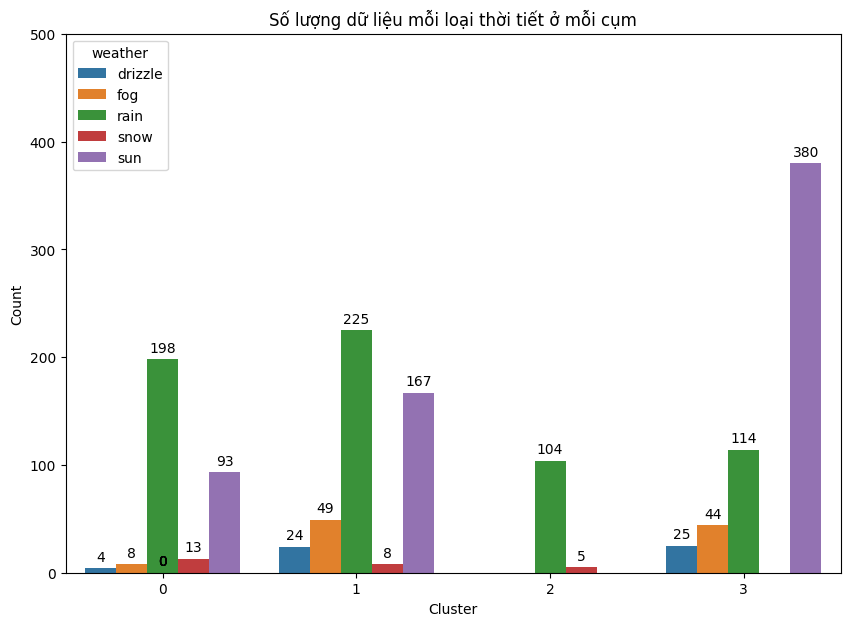

In [ ]:
# Phân cụm df_zscore

df_result = kmean.transform(df_zscore, feature_cols)
df_result.show(5)

import matplotlib.pyplot as plt
import seaborn as sns

# Thống kế số dữ liệu của mỗi cụm
df_tmp = df_result.groupBy('prediction').count().orderBy('prediction')
df_tmp.show()
clusters = df_tmp.select('prediction').rdd.flatMap(lambda r: r).collect()
cluster_counts = df_tmp.select('count').rdd.flatMap(lambda r: r).collect()
plt.figure(figsize=(10, 5))
bars = plt.barh(clusters, cluster_counts)
plt.yticks(clusters)
plt.xlabel('Count')
plt.ylabel('Cluster')
plt.title('Số lượng dữ liệu mỗi cụm')
for bar in bars:
  plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', va='center')
plt.show()

print('\n')

# Thống kê số dữ liệu mỗi loại thời tiết ở mỗi cụm
df_tmp = df_result.groupBy('prediction', 'weather').count().orderBy('prediction', 'weather')
df_tmp.show()
pandas_df = df_tmp.toPandas()

# Create a figure and axes
plt.figure(figsize=(10, 7))

# Create a bar plot
barplot = sns.barplot(x='prediction', y='count', hue='weather', data=pandas_df)

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Số lượng dữ liệu mỗi loại thời tiết ở mỗi cụm')
plt.yticks(range(0, pandas_df['count'].max() + 200, 100))

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 8),
                   textcoords = 'offset points')
plt.show()

In [ ]:
# Dùng hệ số Silhouette đã cài đặt để đánh giá việc phân cụm df_zscore của mô hình

evaluator = SilhouetteEvaluator()
silhouette_score = evaluator.evaluate(df_result)
print('Silhouette score: ', silhouette_score)

Silhouette score:  0.5500840143533829


In [ ]:
# Dùng thư viện để tính hệ số Silhouette

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

feature_cols = ['precipitation_nor', 'temp_max_nor', 'temp_min_nor', 'wind_nor']
vec_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_vec')
df_result2 = vec_assembler.transform(df_result)
evaluator = ClusteringEvaluator(featuresCol='features_vec')
silhouette = evaluator.evaluate(df_result2)
print("Silhouette = " + str(silhouette))

Silhouette = 0.5500840143533835


### Dùng thư viện máy học pyspark MLlib để so sánh với việc tự cài đặt

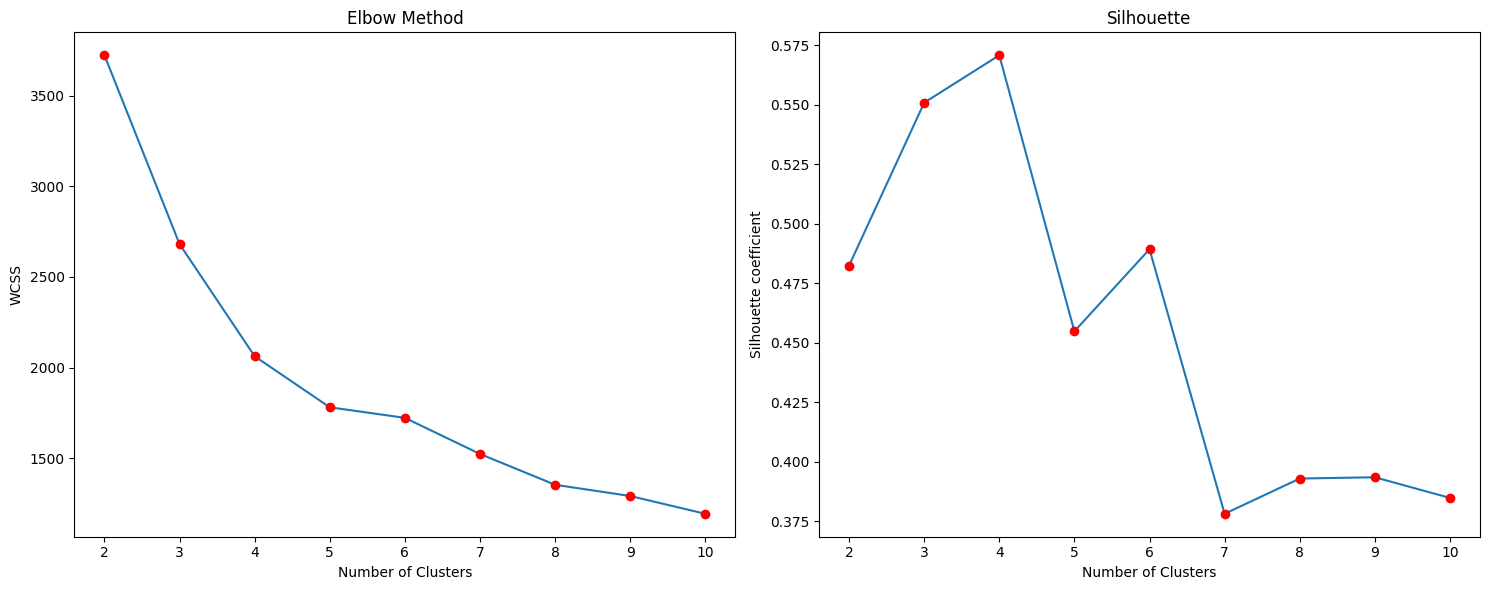

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_train = assembler.transform(df_zscore)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

wcss_list = []
silhouette_list = []

for k in range(2,11):
    kmeans = KMeans(k=k, seed=1) # thư viện pyspark.ml
    model = kmeans.fit(df_train)
    df_result = model.transform(df_train)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(df_result)
    wcss_list.append(model.summary.trainingCost)
    silhouette_list.append(silhouette_score)

# Elbow Method
axs[0].plot(np.arange(2, 11), wcss_list, '-')
axs[0].plot(np.arange(2,11), wcss_list, 'o', color='red')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('WCSS')
axs[0].set_title('Elbow Method')

# Silhouette
axs[1].plot(np.arange(2, 11), silhouette_list, '-')
axs[1].plot(np.arange(2,11), silhouette_list, 'o', color='red')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette coefficient')
axs[1].set_title('Silhouette')

plt.tight_layout()
plt.show()


In [ ]:
# Thực hiện training mô hình trên dữ liệu df_zscore với k = 4

kmeans = KMeans(k=4, seed=1)
kmeans = kmeans.setFeaturesCol("features")
model = kmeans.fit(df_train)

In [ ]:
# Giá trị các centroids và wcss sau khi train

from pyspark.sql.types import *

# Chuyển đổi các nhãn cluster của các centers tạo từ thư viện pyspark.ml tương đồng với các centroids
# của lớp K_Mean nhóm cài đặt bằng cách phân cụm các centers này bằng K_Mean nhóm cài đặt
cols = ['col1', 'col2', 'col3', 'col4']
centers = model.clusterCenters()
centers = [tuple(float(x) for x in centers[i]) + (i,) for i in range(len(centers))]
df_mllib = spark.createDataFrame(centers, [*cols, 'index'])

df_mllib = kmean.transform(df_mllib, cols)
cluster_map = df_mllib.orderBy('index').rdd.map(lambda r: r['prediction']).collect()

centers = df_mllib.orderBy('prediction') \
                  .rdd.map(lambda r: [r[col] for col in cols]) \
                  .collect()

print('centroids:')
for centroid in centers:
  print(centroid)
print('\nWCSS:', model.summary.trainingCost)

centroids:
[0.06663644105947496, -0.6170291543343396, -0.4669751564176076, 1.3274871575070826]
[-0.21022139784876032, -0.8142273827973082, -0.919494995776482, -0.6503450406889882]
[3.0680331905157807, -0.4334865927955932, -0.017892229947060856, 0.8897271245153653]
[-0.36425443624203485, 0.9447760439713934, 0.8836107360037216, -0.30345350726656023]

WCSS: 2061.961114837525


+----------+-------------+--------+--------+----+-------+--------------------+-------------------+--------------------+-------------------+--------------------+----------+
|      date|precipitation|temp_max|temp_min|wind|weather|   precipitation_nor|       temp_max_nor|        temp_min_nor|           wind_nor|            features|prediction|
+----------+-------------+--------+--------+----+-------+--------------------+-------------------+--------------------+-------------------+--------------------+----------+
|2012-01-01|          0.0|    12.8|     5.0| 4.7|drizzle|-0.45349457662362636|-0.4951296045094783| -0.6439912429102402| 1.0146323316031178|[-0.4534945766236...|         0|
|2012-01-02|         10.9|    10.6|     2.8| 4.5|   rain|    1.17819448421541|-0.7944591839129391|  -1.081976146203107| 0.8755333509826664|[1.17819448421541...|         0|
|2012-01-03|          0.8|    11.7|     7.2| 2.3|   rain| -0.3337375813326879|-0.6447943942112089|-0.20600633961737366|-0.6545554358422977|[

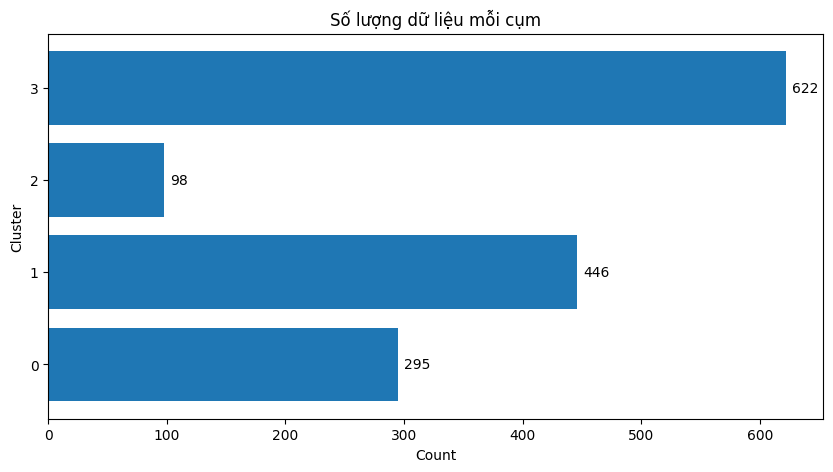



+----------+-------+-----+
|prediction|weather|count|
+----------+-------+-----+
|         0|drizzle|    4|
|         0|    fog|    7|
|         0|   rain|  199|
|         0|   snow|   13|
|         0|    sun|   72|
|         1|drizzle|   24|
|         1|    fog|   48|
|         1|   rain|  204|
|         1|   snow|    9|
|         1|    sun|  161|
|         2|   rain|   94|
|         2|   snow|    4|
|         3|drizzle|   25|
|         3|    fog|   46|
|         3|   rain|  144|
|         3|    sun|  407|
+----------+-------+-----+



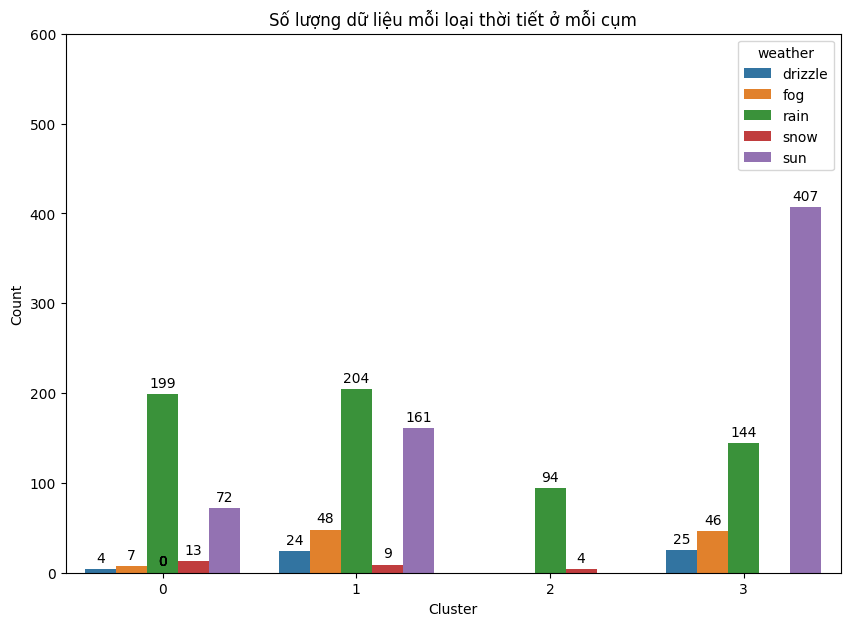

In [ ]:
# Phân cụm df_zscore

from pyspark.sql.types import IntegerType

df_result = model.transform(df_train)
cluster_map_udf = F.udf(lambda prediction: cluster_map[prediction], IntegerType())
df_result = df_result.withColumn('prediction', cluster_map_udf(F.col('prediction')))
df_result.show(5)

import matplotlib.pyplot as plt
import seaborn as sns

# Thống kế số dữ liệu của mỗi cụm
df_tmp = df_result.groupBy('prediction').count().orderBy('prediction')
df_tmp.show()
clusters = df_tmp.select('prediction').rdd.flatMap(lambda r: r).collect()
cluster_counts = df_tmp.select('count').rdd.flatMap(lambda r: r).collect()
plt.figure(figsize=(10, 5))
bars = plt.barh(clusters, cluster_counts)
plt.yticks(clusters)
plt.xlabel('Count')
plt.ylabel('Cluster')
plt.title('Số lượng dữ liệu mỗi cụm')
for bar in bars:
  plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', va='center')
plt.show()

print('\n')

# Thống kê số dữ liệu mỗi loại thời tiết ở mỗi cụm
df_tmp = df_result.groupBy('prediction', 'weather').count().orderBy('prediction', 'weather')
df_tmp.show()
pandas_df = df_tmp.toPandas()

# Create a figure and axes
plt.figure(figsize=(10, 7))

# Create a bar plot
barplot = sns.barplot(x='prediction', y='count', hue='weather', data=pandas_df)

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Số lượng dữ liệu mỗi loại thời tiết ở mỗi cụm')
plt.yticks(range(0, pandas_df['count'].max() + 200, 100))

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 8),
                   textcoords = 'offset points')
plt.show()

In [ ]:
# Hệ số Silhouette
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(df_result)
print('Silhouette score: ', silhouette_score)

Silhouette score:  0.5707688798107416
